# Topo-Cluster Classification with Simple Neural Networks

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# import images
elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

### Plot a few example images

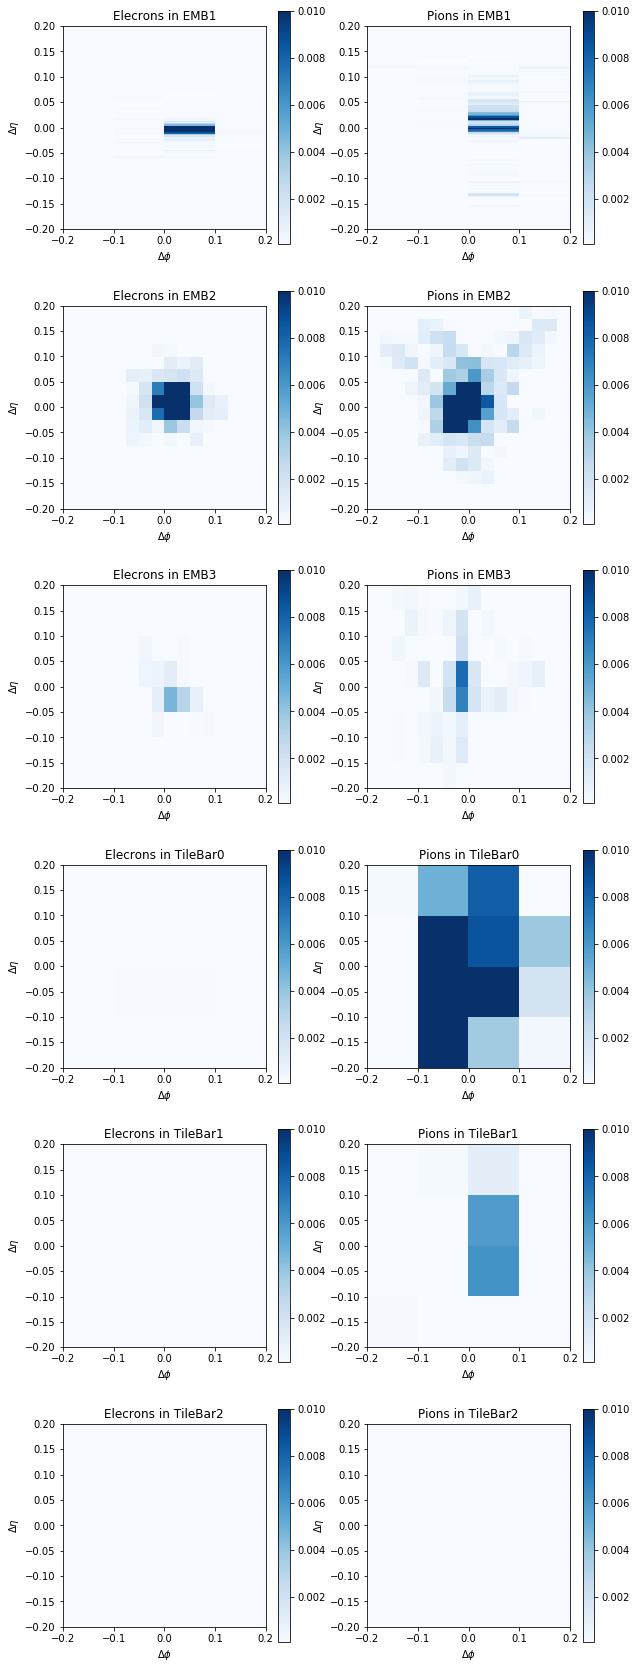

In [2]:
from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 150

# make the plot
plt.cla(); plt.clf()
plt.figure(figsize=(10,30))

i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Elecrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

    # charged pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()

### Plot a few histograms

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


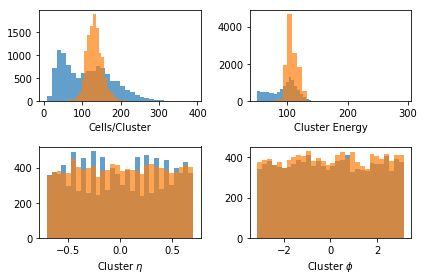

In [3]:
n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, tight_layout=True)

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, alpha=0.7)
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, alpha=0.7)
ax[0,0].set_xlabel('Cells/Cluster')

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, alpha=0.7)
ax[0,1].hist(elec['clusterE'], bins=n_bins, alpha=0.7)
ax[0,1].set_xlabel('Cluster Energy')

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, alpha=0.7)
ax[1,0].hist(elec['clusterEta'], bins=n_bins, alpha=0.7)
ax[1,0].set_xlabel('Cluster $\eta$')

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, alpha=0.7)
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, alpha=0.7)
ax[1,1].set_xlabel('Cluster $\phi$')

plt.show()

## 1. Simple feed-forward Neural Network

In [4]:
# only include the EMB1 layer, flattened
layer = 0
num_pixels = int(len_phi[layer]*len_eta[layer])

X = np.append(elec['EMB1'].reshape((len(elec['EMB1']),num_pixels)),
              pion['EMB1'].reshape((len(pion['EMB1']),num_pixels)), axis=0)

y = np.append(elec['label'], pion['label'], axis=0)

print (X.shape)
print (y.shape)

(22709, 512)
(22709, 1)


In [5]:
# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.cross_validation import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

/usr/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

In [7]:
# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr)
y_te_onehot = np_utils.to_categorical(y_te)
y_vl_onehot = np_utils.to_categorical(y_vl)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

Using TensorFlow backend.


('y_train.shape: ', (17709, 1))
('y_train_onehot.shape: ', (17709, 2))


In [8]:
from keras.models import Sequential
from keras.layers import Dense

# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# build the model
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 427,138
Trainable params: 427,138
Non-trainable params: 0
_________________________________________________________________


In [10]:
from keras.utils import to_categorical
y_tr_onehot = to_categorical(y_tr)
y_te_onehot = to_categorical(y_te)
y_vl_onehot = to_categorical(y_vl)

In [11]:
# fit (train) the model
history = model.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=100, batch_size=200, verbose=2)

# final evaluation of the model
scores = model.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 17709 samples, validate on 1000 samples
Epoch 1/100
 - 1s - loss: 0.6927 - acc: 0.5170 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 2/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6934 - val_acc: 0.5010
Epoch 3/100
 - 1s - loss: 0.6928 - acc: 0.5171 - val_loss: 0.6934 - val_acc: 0.5010
Epoch 4/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6939 - val_acc: 0.5010
Epoch 5/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 6/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 7/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 8/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6936 - val_acc: 0.5010
Epoch 9/100
 - 1s - loss: 0.6926 - acc: 0.5171 - val_loss: 0.6937 - val_acc: 0.5010
Epoch 10/100
 - 1s - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6938 - val_acc: 0.5010
Epoch 11/100
 - 1s - loss: 0.6925 - acc: 0.5171 - val_loss: 0.6933 - val_acc: 0.5010
Epoch 12/100
 - 1s - loss

['acc', 'loss', 'val_acc', 'val_loss']


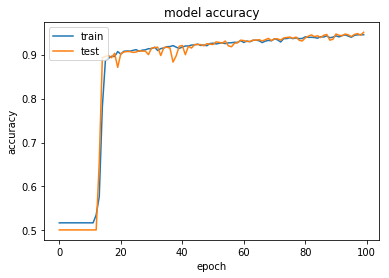

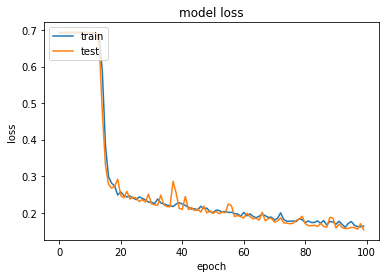

In [12]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# Plot ROC curve

from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_te)
fpr, tpr, thres = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc = auc(fpr, tpr)

In [27]:
print y_pred[1:10]

[[0.979517   0.02048299]
 [0.99191225 0.00808776]
 [0.9042985  0.09570151]
 [0.99244916 0.00755083]
 [0.843952   0.156048  ]
 [0.87610024 0.12389979]
 [0.03181051 0.96818954]
 [0.98870534 0.01129472]
 [0.7921224  0.20787758]]


In [29]:
y_te_onehot[1:10]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

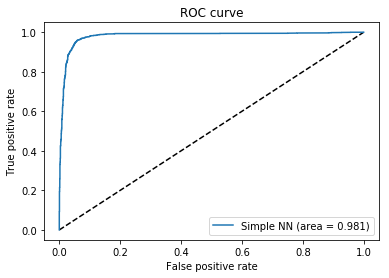

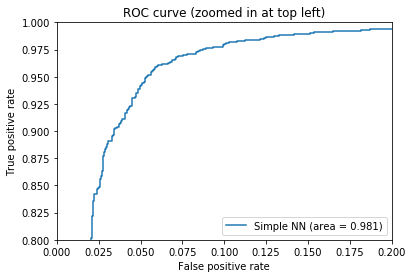

In [37]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Simple NN (area = {:.3f})'.format(auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Simple NN (area = {:.3f})'.format(auc))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()